In [279]:
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.utils import class_weight
from constants import *
import datetime

In [1468]:
x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-800:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-800:]
# y_training = np.array([-1 if y<0 else 0 if y==0 else 1 for y in y_training-2])+1

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)
print(class_weights)
class_weights[0]=1.7
class_weights[1]=1.4
class_weights[2]=0.1
class_weights[3]=1.6
class_weights[4]=1.7
class_weights = tf.cast(tf.constant(class_weights), "float32")

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



[1.40350877 1.75824176 0.47619048 1.24031008 1.23076923]


In [1469]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)
# y_test = np.array([-1 if y<0 else 0 if y==0 else 1 for y in y_test-2])+1

INPUT_DIM = x_test.shape[1:]

# x_test = tf.convert_to_tensor(x_test.astype('float32'))
# y_test = tf.convert_to_tensor(y_test.astype('int32'))
# y_test = tf.one_hot(y_test, 5)

In [1470]:
x_full = np.concatenate((x_training, x_test))
y_full = np.concatenate((y_training, y_test))
x_train_n_inst = int(np.ceil(x_full.shape[0]*0.8))

x_training = x_full[:x_train_n_inst]
y_training = y_full[:x_train_n_inst]

x_test = x_full[x_train_n_inst:]
y_test = y_full[x_train_n_inst:]

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))

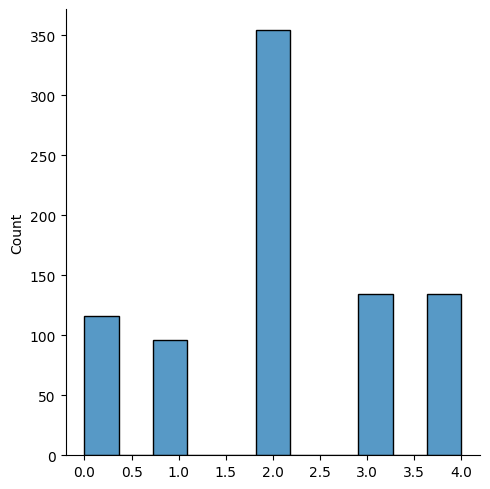

In [1471]:
import seaborn as sns

sns.displot(y_training)

In [1472]:
# class_weights_np = class_weights._numpy()
# class_weights_np[0] = class_weights_np[0]*1.7
# class_weights_np[1] = class_weights_np[1]/3
# class_weights_np[2] = class_weights_np[2]*1.1
# class_weights = tf.cast(tf.convert_to_tensor(class_weights_np), "float32")
# class_weights

In [1473]:
class_weights

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1.7, 1.4, 0.1, 1.6, 1.7], dtype=float32)>

In [1474]:
def weightedLoss(weights=tf.constant([1,1,1])):
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [1475]:
# class_weights_dict[2]=0.01
# class_weights_dict[3]=0.01

In [1476]:
lr_scheduler_plt = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [1477]:

def create_mlp_model(input_shape:Tuple[int, int], 
                     layer_number:int, 
                     neuron_number:List[int], 
                     activation:str|None="relu",
                     loss:str|None = "mae",
                     optimizer:str|None="adam") -> tf.keras.Model:

    """Creates a simple MLP regression model with 3-layers."""
    print(loss)

    layers = [tf.keras.layers.Dense(neuron_number[i], activation=activation) for i in range(layer_number)]
    layers.insert(0, tf.keras.layers.InputLayer(input_shape=input_shape))
    layers.insert(1, tf.keras.layers.Flatten())
    layers.append(tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax"))
    # layers.append(tf.keras.layers.Maximum())

    model = tf.keras.Sequential(layers)
    model.compile(
        # loss=loss,
        loss=weightedLoss(class_weights),
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        # optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.00032415, epsilon=7.3884e-3),
        optimizer = tf.keras.optimizers.legacy.Adadelta(learning_rate=0.001, epsilon=1e-3, rho=0.95),
        # optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
        # optimizer = optimizer,
        metrics=["acc"]
    )

    return model

In [1478]:
model = create_mlp_model(INPUT_DIM, 5, [112, 116, 27, 40, 33], activation="tanh")

mae


In [1479]:
## model training 
history = model.fit(x_training, 
                    y_training, 
                    epochs=100, 
                    batch_size=64, 
                    verbose=1, 
                    validation_split=0.10, 
                    # class_weight=class_weights_dict,
                    callbacks=[lr_scheduler_plt]
                    )

Epoch 1/100
12/12 [==============================] - 2s 88ms/step - loss: 1.5833 - acc: 0.2547 - val_loss: 1.2299 - val_acc: 0.3571 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 1.5680 - acc: 0.3080 - val_loss: 1.2152 - val_acc: 0.4048 - lr: 0.0010
Epoch 3/100
12/12 [==============================] - 0s 24ms/step - loss: 1.5553 - acc: 0.3440 - val_loss: 1.2042 - val_acc: 0.4048 - lr: 0.0010
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 1.5440 - acc: 0.3587 - val_loss: 1.1949 - val_acc: 0.4167 - lr: 0.0010
Epoch 5/100
12/12 [==============================] - 0s 10ms/step - loss: 1.5401 - acc: 0.3640 - val_loss: 1.1892 - val_acc: 0.4167 - lr: 0.0010
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 1.5310 - acc: 0.3680 - val_loss: 1.1828 - val_acc: 0.4286 - lr: 0.0010
Epoch 7/100
12/12 [==============================] - 0s 11ms/step - loss: 1.5281 - acc: 0.3720 - val_loss: 1.1780 - val_acc: 0.452

In [1480]:
model.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_71 (Flatten)        (None, 900)               0         
                                                                 
 dense_408 (Dense)           (None, 112)               100912    
                                                                 
 dense_409 (Dense)           (None, 116)               13108     
                                                                 
 dense_410 (Dense)           (None, 27)                3159      
                                                                 
 dense_411 (Dense)           (None, 40)                1120      
                                                                 
 dense_412 (Dense)           (None, 33)                1353      
                                                                 
 dense_413 (Dense)           (None, 5)               

In [1481]:
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

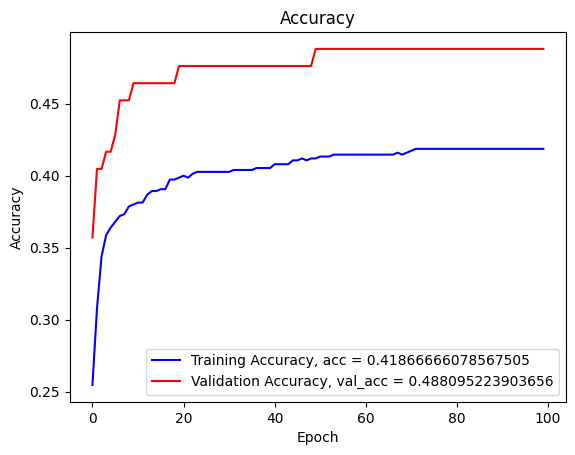

In [1482]:
plt.plot(range(len(accuracy)), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(len(accuracy)), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

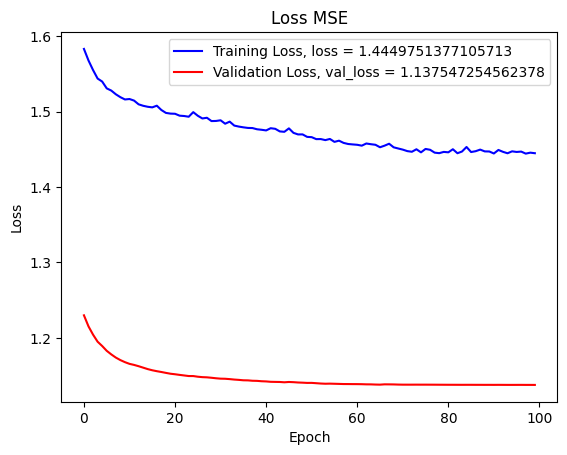

In [1483]:
plt.plot(range(len(accuracy)), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(len(accuracy)), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [1484]:
y_test_2 = np.where(y_test==2)[0].shape[0]
y_test_2/y_test.shape[0]

0.5240384615384616

In [1485]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 27ms/step - loss: 1.1801 - acc: 0.4808


[1.18006432056427, 0.48076921701431274]

In [1486]:
from sklearn.metrics import classification_report, confusion_matrix

In [1487]:
#Predict
y_prediction = model.predict(x_test)

y_prediction = np.argmax (y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(classification_report(y_test, y_prediction))

7/7 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.50      0.06      0.10        18
           1       0.25      0.04      0.06        27
           2       0.52      0.86      0.65       109
           3       0.25      0.05      0.08        22
           4       0.18      0.09      0.12        32

    accuracy                           0.48       208
   macro avg       0.34      0.22      0.20       208
weighted avg       0.40      0.48      0.38       208



<Axes: >

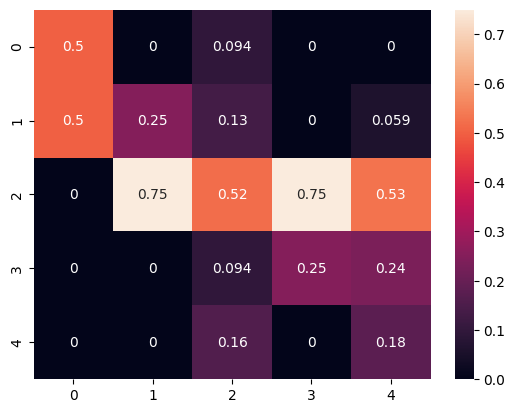

In [1488]:
sns.heatmap(result, annot=True)

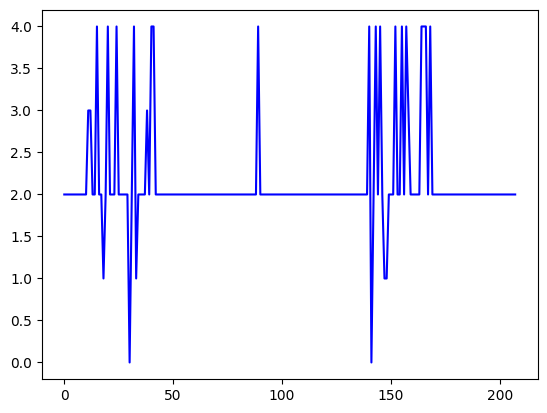

In [1489]:
plt.plot(range(len(y_prediction)), y_prediction[:], "-b", label = f"Predicted")

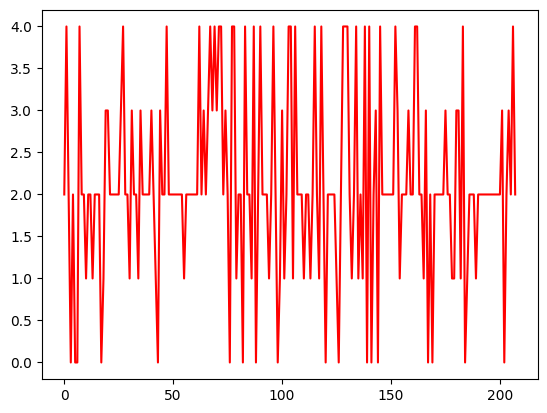

In [1490]:
plt.plot(range(len(y_prediction)), y_test[:], "-r", label = f"Actual")

In [1491]:
right_idx = np.where(y_prediction == y_test)[0]
idxs = range(len(y_prediction))
not_right_idx = [i for i in idxs if i not in right_idx]
right = np.zeros_like(y_prediction)
right[right_idx] = y_prediction[right_idx]
right[not_right_idx] = 5

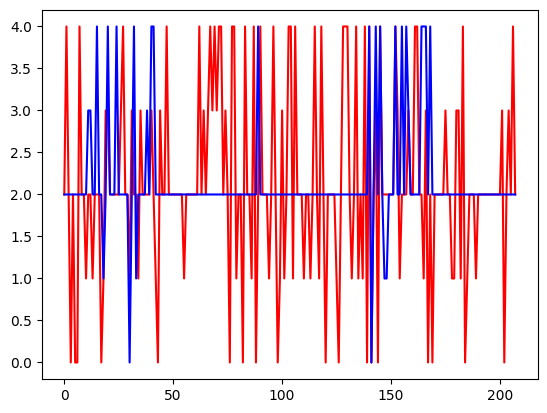

In [1492]:
plt.plot(range(len(y_prediction)), y_test[:], "r", label = f"Actual")
plt.plot(range(len(y_prediction)), y_prediction[:], "b", label = f"Predicted")
# plt.plot(range(len(y_prediction)), right[:], "g", label = f"Right")
plt.show()

In [1493]:
def foo(y_test, y_prediction):
    y_test = y_test-2
    y_test = np.array([-1 if i<0 else 0 if i==0 else 1 for i in y_test])
    y_prediction = y_prediction-2
    y_prediction = np.array([-1 if i<0 else 0 if i==0 else 1 for i in y_prediction])

    return np.where(y_test == y_prediction)[0].shape[0]/y_test.shape[0]

In [1494]:
foo(y_test, y_prediction)

0.5048076923076923

In [1497]:
os.path.join("models/mlp/class", f"{datetime.datetime.now().strftime('%Y-%m-%d-%H')}.h5")

'models/mlp/class/2023-06-04-15.h5'

In [1505]:
model.save(os.path.join("models/mlp/class", f"{datetime.datetime.now().strftime('%Y-%m-%d-%H')}.h5"))

In [590]:
np.unique(y_prediction, return_counts=True)

(array([0, 1, 2, 3, 4]), array([  8,   6, 175,  10,   9]))

In [144]:
y_prediction.shape

(395,)

In [145]:
y_prediction[200:300]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [146]:
np.unique(y_training, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([ 82,  83, 246, 266, 114, 109]))

In [1513]:
config = model.get_config()

In [1552]:
import json
def weights_to_json(weights:np.ndarray[np.ndarray]):
    print(len(weights))
    weight_dict = {}
    for i, w in enumerate(weights):
        if i%2==0 and i>0:
            print(w.shape)
            idx = int((i-2)/2)
            weight_dict[f"layer_{idx}"] = {}
            weight_dict[f"layer_{idx}"]["n_rows"] = w.shape[0]
            weight_dict[f"layer_{idx}"]["n_columns"] = w.shape[1]
            weight_dict[f"layer_{idx}"]["weights"] = w.flatten().tolist()

    print(weight_dict)
    json.dump(weight_dict, open(f"models/mlp/class/weights/{datetime.datetime.now().strftime('%Y-%m-%d-%H')}.json", "w"))


In [1553]:
weights_to_json(weights_list)

12
(112, 116)
(116, 27)
(27, 40)
(40, 33)
(33, 5)
{'layer_0': {'n_rows': 112, 'n_columns': 116, 'weights': [0.02524392493069172, -0.12379385530948639, -0.057635433971881866, 0.016682621091604233, 0.05079537257552147, 0.022528592497110367, -0.024476150050759315, 0.1130668893456459, 0.11608340591192245, 0.047746442258358, -0.08588006347417831, -0.06881362199783325, -0.03272010013461113, 0.13497476279735565, 0.13692866265773773, 0.10828013718128204, 0.012010997161269188, -0.10871681571006775, -0.04294569417834282, -0.11010168492794037, 0.09755140542984009, 0.053490232676267624, -0.043715011328458786, -0.11383550614118576, 0.09670719504356384, 0.08049710094928741, -0.11263415217399597, -0.15920481085777283, 0.11716806888580322, -0.080523781478405, -0.042374368757009506, -0.1008230596780777, 0.0940449982881546, -0.07313218712806702, 0.09820879995822906, -0.07111436128616333, 0.14800357818603516, -0.05431180074810982, -0.06648913025856018, -0.11474385112524033, 0.08392174541950226, -0.050437

# Grid Search

In [2]:
import keras_tuner as kt
from pathlib import Path

from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.utils import class_weight
from constants import *

In [3]:
x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-800:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-800:]
# y_training = np.array([-1 if y<0 else 0 if y==0 else 1 for y in y_training-2])+1

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)*2
# class_weights[1]=class_weights[1]/2
class_weights = tf.cast(tf.constant(class_weights), "float32")

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [4]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)
# y_test = np.array([-1 if y<0 else 0 if y==0 else 1 for y in y_test-2])+1

INPUT_DIM = x_test.shape[1:]

In [5]:
x_full = np.concatenate((x_training, x_test))
y_full = np.concatenate((y_training, y_test))
x_train_n_inst = int(np.ceil(x_full.shape[0]*0.8))

x_training = x_full[:x_train_n_inst]
y_training = y_full[:x_train_n_inst]

x_test = x_full[x_train_n_inst:]
y_test = y_full[x_train_n_inst:]

INPUT_DIM = x_training.shape[1:]

val_n = int(len(x_training)*0.1)

x_training = x_training[:-val_n]
y_training = y_training[:-val_n]

x_val = x_training[-val_n:]
y_val = y_training[-val_n:]

print(f"Shape of training data: {x_training.shape}")
print(f"Shape of training labels: {y_training.shape}")
print(f"Shape of validation data: {x_val.shape}")
print(f"Shape of validation labels: {y_val.shape}")
print(f"Shape of test data: {x_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))

x_val = tf.convert_to_tensor(x_val.astype('float32'))
y_val = tf.convert_to_tensor(y_val.astype('int32'))

Shape of training data: (861, 27, 36)
Shape of training labels: (861,)
Shape of validation data: (95, 27, 36)
Shape of validation labels: (95,)
Shape of test data: (239, 27, 36)
Shape of test labels: (239,)


In [6]:
def weightedLoss(weights=tf.constant([1,1,1,1,1])):
    @tf.function(reduce_retracing=True)
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [7]:
@tf.function(reduce_retracing=True)
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    if tf.cast(predicted_positives, 'float32')<0.001:
        predicted_positives = tf.convert_to_tensor([1000000.00])
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

@tf.function(reduce_retracing=True)
def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [8]:
def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=1, max_value=5, default=2)
    n_neurons_1 = hp.Int('n_neurons_1', min_value=16, max_value=128, default=32)
    n_neurons_2 = hp.Int('n_neurons_2', min_value=16, max_value=128, default=32)
    n_neurons_3 = hp.Int('n_neurons_3', min_value=16, max_value=128, default=32)
    n_neurons_4 = hp.Int('n_neurons_4', min_value=16, max_value=128, default=32)
    n_neurons_5 = hp.Int('n_neurons_5', min_value=16, max_value=128, default=32)
    n_neurons = [n_neurons_1, n_neurons_2, n_neurons_3, n_neurons_4, n_neurons_5]
    # n_neurons = hp.Int('n_neurons', min_value=16, max_value=128, default=32)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    optimizer = hp.Choice('optimizer', ['adam', 'adagrad', 'adadelta'])
    weighted = hp.Boolean('weighted', default=True)
    epsilon = hp.Float('epsilon', min_value=1e-10, max_value=1e-2, sampling='log')
    rho = hp.Float('rho', min_value=0.7, max_value=0.98, sampling='log')

    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'adagrad':
        optimizer = tf.keras.optimizers.legacy.Adagrad(learning_rate=learning_rate, epsilon=epsilon)
    elif optimizer == 'adadelta':
        optimizer = tf.keras.optimizers.legacy.Adadelta(learning_rate=learning_rate, epsilon=epsilon, rho=rho)
        

    if weighted:
        loss=weightedLoss(class_weights)
    else:
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=INPUT_DIM))
    model.add(tf.keras.layers.Flatten())
    for i in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons[i], activation='tanh'))
    model.add(tf.keras.layers.Dense(5, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['acc', precision, recall])
    
    return model

In [9]:
class ClassHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)
    
    def fit(self, hp, model, X, y, **kwargs):
        # batch_size = hp.Int('batch_size', min_value=18, max_value=128, step=16)
        return model.fit(X, y, **kwargs)

In [10]:
hyperband_tuner = kt.Hyperband(ClassHyperModel(),
                               objective=kt.Objective('val_acc', direction='max'),
                               seed=42,
                               max_epochs=50,
                               hyperband_iterations=2,
                               factor=3,
                               overwrite=True,
                               directory = "models",
                               project_name = "trading_bot")

In [15]:
root_logdir = Path(hyperband_tuner.project_dir)/"tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
lr_scheduler_plt = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
hyperband_tuner.search(x_training, y_training, 
                       validation_data=(x_val, y_val),
                       epochs=50,    
                       callbacks=[tensorboard_cb, lr_scheduler_plt, early_stopping])

Trial 86 Complete [00h 06m 56s]
val_acc: 0.3684210479259491

Best val_acc So Far: 1.0
Total elapsed time: 00h 30m 45s

Search: Running Trial #87

Value             |Best Value So Far |Hyperparameter
4                 |4                 |n_hidden
62                |109               |n_neurons_1
75                |123               |n_neurons_2
60                |110               |n_neurons_3
59                |44                |n_neurons_4
49                |78                |n_neurons_5
0.00093437        |0.00070724        |learning_rate
adagrad           |adam              |optimizer
True              |False             |weighted
7.3738e-06        |4.1198e-09        |epsilon
0.78129           |0.72628           |rho
50                |17                |tuner/epochs
0                 |6                 |tuner/initial_epoch
0                 |3                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/50
27/27 [==============================] - 40s 1

: 

: 

In [11]:
hyperband_tuner.results_summary(86)

Results summary
Results in models/trading_bot
Showing 86 best trials
Objective(name="val_acc", direction="max")


In [ ]:
best_hps = hyperband_tuner.get_best_hyperparameters(num_trials = 86)[38]

try:
    trial_id = best_hps.get('trial_id', None)
except Exception:
    trial_id = None

print(f"""
The hyperparameter search is complete. \nTrial ID: {trial_id}\nNumber of layers: {best_hps.get("n_hidden")}\nNumber of neurons: {best_hps.get('n_neurons')}\nLearning rate: {best_hps.get('learning_rate')}\n Optimizer: {best_hps.get('optimizer')}\nWeighted: {best_hps.get('weighted')}\nEpsilon: {best_hps.get('epsilon')}\nRho: {best_hps.get('rho')}
""")

In [235]:
best_model = hyperband_tuner.hypermodel.build(best_hps)

In [236]:
history = best_model.fit(x_training, y_training, 
                validation_data=(x_val, y_val),
                epochs=30,    
                callbacks=[tensorboard_cb, lr_scheduler_plt])

Epoch 1/30
27/27 [==============================] - 6s 166ms/step - loss: 1.6719 - acc: 0.2242 - precision: 14.7778 - recall: 1.9365 - val_loss: 1.6116 - val_acc: 0.2737 - val_precision: 18.0000 - val_recall: 1.9352 - lr: 5.6183e-05
Epoch 2/30
27/27 [==============================] - 1s 56ms/step - loss: 1.5971 - acc: 0.3264 - precision: 11.2223 - recall: 1.9489 - val_loss: 1.5854 - val_acc: 0.3053 - val_precision: 36.3333 - val_recall: 2.0152 - lr: 5.6183e-05
Epoch 3/30
27/27 [==============================] - 1s 37ms/step - loss: 1.5505 - acc: 0.3508 - precision: 26.2778 - recall: 1.9090 - val_loss: 1.5718 - val_acc: 0.3053 - val_precision: 26.3333 - val_recall: 1.9316 - lr: 5.6183e-05
Epoch 4/30
27/27 [==============================] - 1s 34ms/step - loss: 1.5197 - acc: 0.3717 - precision: 19.2778 - recall: 1.7992 - val_loss: 1.5661 - val_acc: 0.3053 - val_precision: 17.5000 - val_recall: 1.8746 - lr: 5.6183e-05
Epoch 5/30
27/27 [==============================] - 1s 29ms/step - loss

In [237]:
best_model.evaluate(x_test, y_test)

8/8 [==============================] - 1s 82ms/step - loss: 1.5383 - acc: 0.3808 - precision: 5.3563 - recall: 1.4997


[1.5383074283599854, 0.38075312972068787, 5.356339454650879, 1.499733328819275]

In [238]:
from sklearn.metrics import classification_report, confusion_matrix

In [239]:
#Predict
y_prediction = best_model.predict(x_test)

y_prediction = np.argmax (y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(classification_report(y_test, y_prediction))
print(result)

8/8 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.05      0.05      0.05        20
           1       0.00      0.00      0.00        32
           2       0.52      0.63      0.57       126
           3       0.10      0.12      0.11        26
           4       0.22      0.23      0.22        35

    accuracy                           0.38       239
   macro avg       0.18      0.20      0.19       239
weighted avg       0.32      0.38      0.35       239

[[0.05263158 0.         0.10526316 0.06666667 0.02702703]
 [0.15789474 0.         0.11842105 0.3        0.05405405]
 [0.63157895 1.         0.51973684 0.43333333 0.56756757]
 [0.10526316 0.         0.10526316 0.1        0.13513514]
 [0.05263158 0.         0.15131579 0.1        0.21621622]]


In [32]:
%reload_ext tensorboard
%tensorboard --logdir models/trading_bot/tensorboard --port=7007